In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
%matplotlib inline

In [2]:
latent_size = 32
hidden1_size = 64
hidden2_size = 128
image_size = 784
num_epochs = 100
batch_size = 64
sample_dir = 'samples'
save_dir = 'save'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor()])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../../data/',
                                   train=True,
                                   transform=transform)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)


tensor(0.)
tensor(1.)


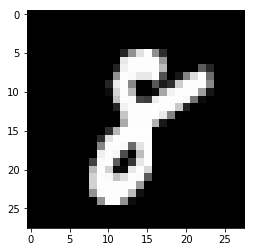

In [5]:
imgs, lbls = next(iter(data_loader))
imgs[0].data.shape
print(imgs.data.min())
print(imgs.data.max())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden2_size),
    nn.ReLU(),
    nn.Linear(hidden2_size, hidden1_size),
    nn.ReLU(),
    nn.Linear(hidden1_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden1_size),
    nn.ReLU(),
    nn.Linear(hidden1_size, hidden2_size),
    nn.ReLU(),
    nn.Linear(hidden2_size, image_size),
    nn.Sigmoid())
D.to(device)
G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=5e-4)
g_optimizer = torch.optim.Adam(G.parameters(), lr=5e-4)

In [7]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

Epoch 100 / 100 took   7.16 seconds
Total training time till this epoch was 729.53 seconds


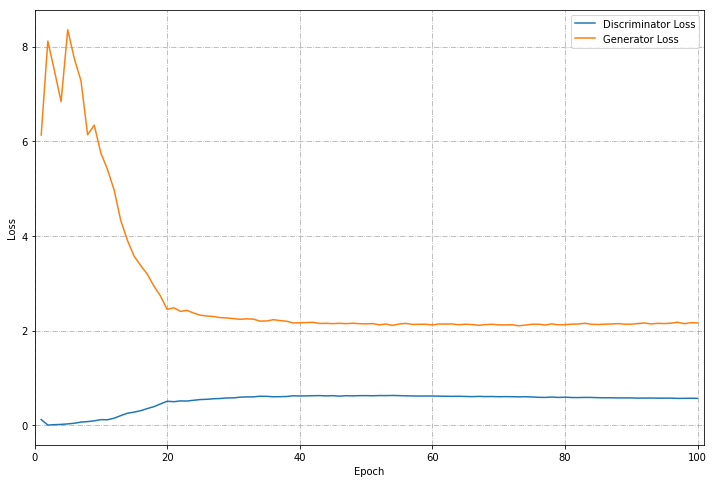

In [8]:
# Statistics to be saved
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

# Start training
start_time = time.time()
total_step = len(data_loader)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for i, (images, _) in enumerate(data_loader):
        images = images.view(images.size(0), -1)
        images = images.to(device)
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        reset_grad()
        z = torch.randn(images.size(0), latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        # If D is trained so well, then don't update
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        reset_grad()
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        real_labels = torch.ones(fake_images.size(0), 1).to(device)
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()
        # =================================================================== #
        #                          Update Statistics                          #
        # =================================================================== #
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))
    
    clear_output(wait=True)
    print('Epoch %d / %d took %6.2f seconds' % (epoch+1, num_epochs, time.time()-epoch_start_time))
    print('Total training time till this epoch was %6.2f seconds' % (time.time()-start_time))
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(1-images.data, os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(1-fake_images.data, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.set_xlim([0, num_epochs + 1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(1, epoch + 2), d_losses[:epoch+1], label='Discriminator Loss')
    plt.plot(range(1, epoch + 2), g_losses[:epoch+1], label='Generator Loss')    
    plt.legend()
    ax.grid(linestyle='-.')
    plt.show()

    # Save model at checkpoints
    if (epoch+1) % 10 == 0:
        torch.save(G.state_dict(), os.path.join(save_dir, 'G--{}.ckpt'.format(epoch+1)))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D--{}.ckpt'.format(epoch+1)))


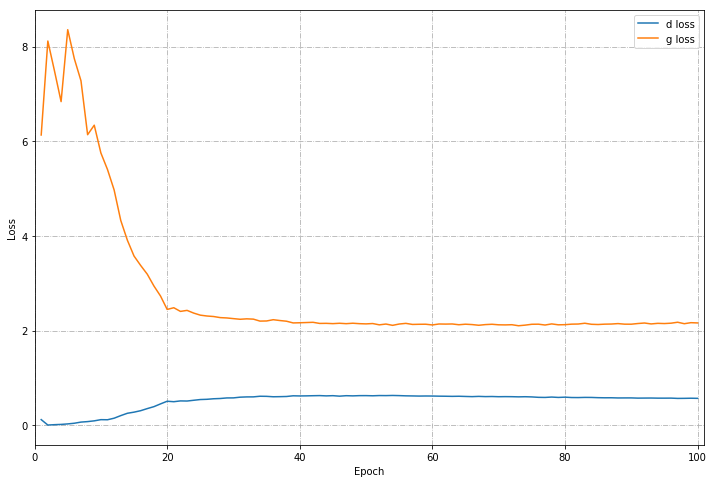

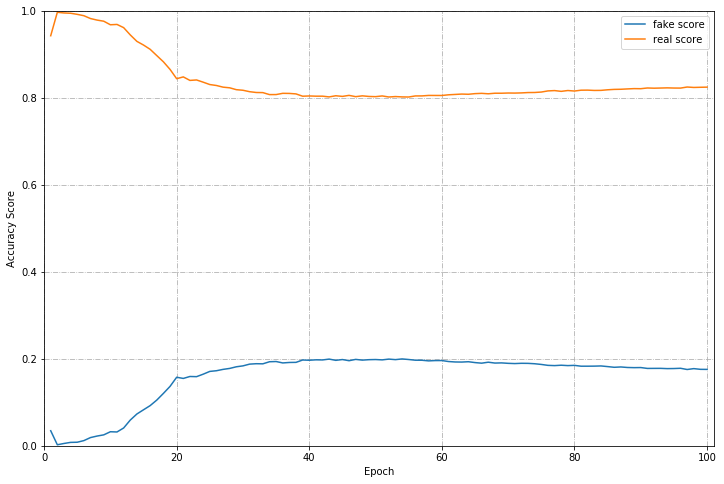

In [9]:
np.save(os.path.join(save_dir, 'd_losses.npy'), d_losses)
np.save(os.path.join(save_dir, 'g_losses.npy'), g_losses)
np.save(os.path.join(save_dir, 'fake_scores.npy'), fake_scores)
np.save(os.path.join(save_dir, 'real_scores.npy'), real_scores)

plt.figure(figsize=(12,8))
ax = plt.gca()
ax.set_xlim([0, num_epochs + 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), d_losses, label='d loss')
plt.plot(range(1, num_epochs + 1), g_losses, label='g loss')    
plt.legend()
ax.grid(linestyle='-.')
plt.savefig(os.path.join(save_dir, 'loss.png'))

plt.figure(figsize=(12,8))
ax = plt.gca()
ax.set_xlim([0, num_epochs + 1])
ax.set_ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
plt.plot(range(1, num_epochs + 1), real_scores, label='real score')    
plt.legend()
ax.grid(linestyle='-.')
plt.savefig(os.path.join(save_dir, 'accuracy.png'))